In [1]:
import torch
import torchmetrics
import matplotlib.pyplot as plt
from build_dataset import SegyDataset
from vit_pytorch import ViT, MAE
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

In [2]:
training_data = SegyDataset('../../../Downloads/F3_Demo_2020/Rawdata/Seismic_data.sgy', "train", 256)
test_data = SegyDataset('../../../Downloads/F3_Demo_2020/Rawdata/Seismic_data.sgy', "test", 256)

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 256, 256])
Labels batch shape: torch.Size([64])


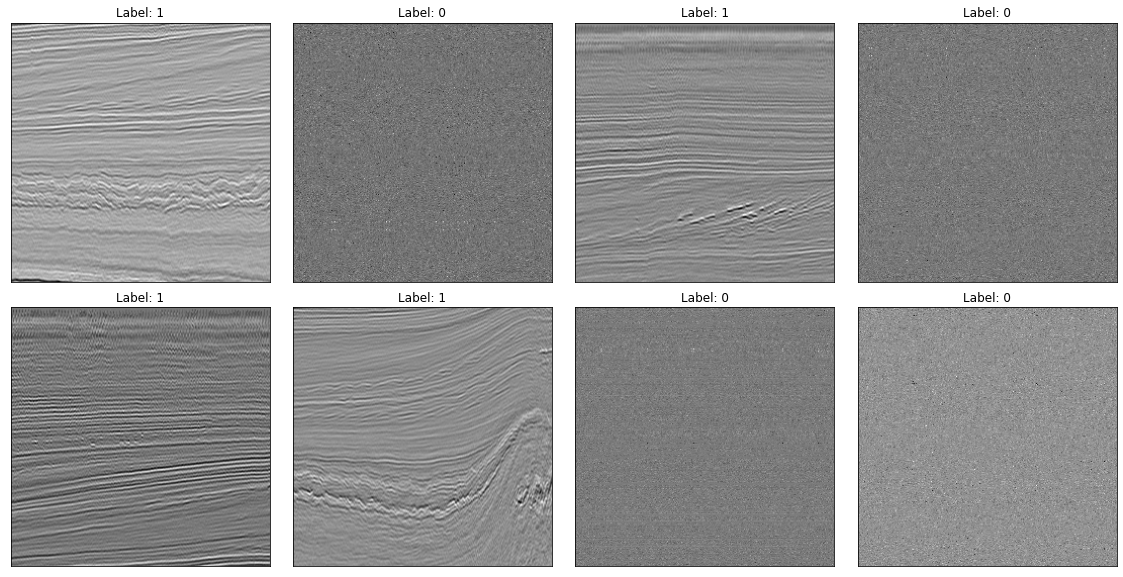

In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig, ax = plt.subplots(2,4,figsize=(20,10), sharex=True, sharey=True)
for xx in range(8):
    img = train_features[xx][0].squeeze()
    label = train_labels[xx]
    ii = xx//4
    jj = xx%4
    ax[ii,jj].imshow(img, cmap="gray")
    ax[ii,jj].set_title(f"Label: {label}")
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
plt.subplots_adjust(hspace=0.1, wspace=0.05)
# plt.savefig('TrainData.png', dpi=150)

In [5]:
v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels = 1
)

optimizer = AdamW(v.parameters())

In [ ]:
criterion = CrossEntropyLoss()

for jj in range(5):
    train_loss = 0
    
    for images, labels in train_dataloader:
        preds = v(images)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {jj}: train loss {train_loss}")
# save your improved vision transformer
torch.save(v.state_dict(), './trained-vit.pt')

In [ ]:
v.eval()
for images, labels in test_dataloader:
    preds = v(images)
    preds = preds.softmax(dim=-1)
    acc = torchmetrics.functional.accuracy(preds, target)
    print(acc)

In [ ]:
mae = MAE(
    encoder = v,
    masking_ratio = 0.25,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [ ]:
# for jj in range(10):
#     train_loss = 0
    
#     for images, labels in train_dataloader:
#         loss = mae(images) 
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#     print(f"Epoch {jj}: train loss {train_loss}")

# # save your improved vision transformer
# torch.save(v.state_dict(), './trained-vit.pt')